In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
cd ..

/


In [ ]:
df = pd.read_csv("./df_class2.csv")
#"/Users/canerozer/Desktop/BU/FALL2023/CS505/Final_Project/data/df_class1.csv"

In [ ]:
df.head()

,Id,Text
0,195370,An Unexplained Anime Review I was very anxious...
1,1213850,Disappointing Night Saw this film recently on ...
2,280462,It was just okay. The end of the film has mode...
3,1002289,Not my pick on a good pilates workout I would ...
4,1393851,"Has it's share of laughs, but goes overboard w..."


In [ ]:
docs= df["Text"].to_list()

docs[:10]

["An Unexplained Anime Review I was very anxious to see the Uncut version of Kite, or kee-tay as I called it, and I finally manage to see that Anime, but when I see the entire movie.man, it was very hard to explain. First off, the plot is very questionable, this movie has got to be the first I've ever seen that deals with a lot of.'DEPTH'. There are still many things in this movie that I still don't understand What's the real reason that Akai wants Sawa to assasinate certain innocent people, why can Sawa just have the heart to decide not to kill those people and find a solution to that, and mainly, why Akai killed Sawa's parents? There are many more questions unanswered, but I don't want to spoil it to the people, all I can say is that none of this makes sense, except for the fact that Akai is a perverted, child-raping nutcase! The animation and characters in this anime is good, but not at a same level as 'Ghost In The Shell', and everything else..just forget it!Overall.this is very ha

<ipython-input-9-0dc1d487ac7d>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

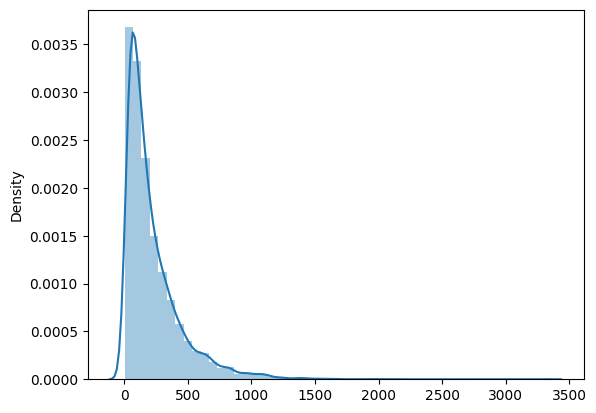

In [ ]:
doc_lengths = []

for doc in docs:

    # get rough token count distribution
    tokens = nltk.word_tokenize(doc)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
np.average(doc_lengths)

223.11136954439732

In [ ]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.03447804077165139

Even though the average words in texts is too much there are still not too much texts that have more than 768 words.

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium



vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))



The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [ ]:
batch_size=2

In [ ]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]


In [ ]:
dataset = GPT2Dataset(docs, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,578 training samples
  731 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 4 #YOU MAY LOWER THIS
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,289. Loss: 1.9134312868118286.   Elapsed: 0:00:53.
0:  bipartisan,y.gov, he would find it difficult to keep the door open for you to get through your taxes. He wants to know if you get a lot of money from a donor or an unknown donor, he wants to know how much you spend on things.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,289. Loss: 0.5344114303588867.   Elapsed: 0:01:48.
0:  increasingThis is theennial season of summer here on Broadway. In the summer it is called 'The Dance of Hamlet' and 'Songs of Hamlet' or 'Songs of Hamlet'. There are many such things. There is a Shakespearean, or the Hamlet plays of Hamlet. It is in the summer, and the songs are mostly of the Hamlet variety which is to be admired at an event. The performances are mainly of the Hamlet type as they are very well remembered, but there are many more such plays in the theatres and there is also a Hamlet play, called 'Hamlet's Comedy' and a Hamlet play, called 'The Dance of Hamlet'.It is this season that it is said that Hamlet's Comedy plays are very good at a performance which could be done at any given time. The main problem is that Hamlet is played only in the Broadway plays of Hamlet, which are very good at a Comedy,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,289. Loss: 0.9062079787254333.   Elapsed: 0:02:43.
0: dayIf you want to run, don't do it! If you want to run, don't get your hands dirty! It's not fair, and your goal may not be met!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,289. Loss: 1.1410884857177734.   Elapsed: 0:03:35.
0:  Hanga to me for having some amazing lines!I'll definitely recommend this movie!I hope they can find some quality footage from this movie and make it a worthwhile movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,289. Loss: 2.1036102771759033.   Elapsed: 0:04:28.
0:  foodsWe should know this film and film star Donald Pleasent does not make good movies, as seen in the trailer. He looks and acts exactly like a comic relief. It is really just a big, silly movie, that does not have its moments, or do it's good. Maybe its just a shame that people didn't see these movies before.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,289. Loss: 0.6910409331321716.   Elapsed: 0:05:20.
0:  trailThis is a wonderful DVD with great acting by the cast. Great extras. This must be a DVD.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,289. Loss: 1.7527543306350708.   Elapsed: 0:06:11.
0: intendThe original  had lots of problems, not the least of which was that this movie had an all out war scene.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,289. Loss: 2.9205400943756104.   Elapsed: 0:07:02.
0:  surroundThe film is a total waste If this review has you in a good mood, you will fall in love with a certain piece of action film. In fact, I would have loved it to be the best movie ever produced. The film is full of a good mix of slapstick humor, action sequences and intense fighting. It's an example of when the filmmakers tried to make a story for each genre to be one with the other, and to connect each film with reality. This is what makes the entire film so funny and so funny. It works with my tastes. The characters are pretty predictable, and the action is very short and almost pointless, though the rest of the time it doesn't bother my tastes. There is little in the movie that could make you fall asleep with any interest. I could watch this as soon as I get on it. It just doesn't make it worth buying. It goes nowhere fast.It is a movie about the effects. You don't see it any


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,289. Loss: 1.611754059791565.   Elapsed: 0:07:56.
0:  reflexNot so good as hoped- Well, I don't know if it's meant to be a positive or a negative reaction- Well, maybe to remind myself that I love reading and watching movies and I like movies that make up my attention. I like to laugh, too. As someone who like a good story, I really wanted to like this one as soon as possible. And so, I gave it two stars instead of one; so, it was a bit more fun seeing the movie from the other viewpoint. That was probably enough for me to give it two stars, because it's not going to bring as many laughs as a popcorn flick. If I don't like this movie, I won't get it again. But I won't waste my time on buying the extra.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,289. Loss: 0.5731262564659119.   Elapsed: 0:08:48.
0:  displayDoor to door to door
umbers and traps


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,289. Loss: 0.319905161857605.   Elapsed: 0:09:39.
0:  pastorNot very good I bought this on a low budget and after the video was played it was good looking. Unfortunately I can't recommend it to anyone. The video was edited badly with too much detail and too much padding for the camera to do a decent job. A lot of it did not look good, and the subtitles used to be annoying. The audio is low quality, but I couldn't find anything I wanted, or even understood the subtitles.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,289. Loss: 1.1371746063232422.   Elapsed: 0:10:31.
0:  illicitA great story with nothing new to tell is an intriguing piece of filmmaking. But it is not, in fact, the story of all films of Hollywood. When the studio was first introduced the story involved a family of three friends who were taking care of their three young daughters in their new home. They were told that they were going to rent out their home which the children had already purchased. That the family was getting so close to being killed. They saw something happen to the family and left them, thinking that it was all about a young girl, who would help them get away from the house. It seems that this story is only being told to a small circle of film students, who do not have money and who do not have room or even a living room and living room. That's why the film students do not get much screen time. In order to get to the film students, they meet the young girl. Their mother, who is trying to help th

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,289. Loss: 1.0590291023254395.   Elapsed: 0:11:24.
0:  LiberationIt's not funny at all The movie was well acted, the dialogue and visuals well done and that's all I paid all the hype. I'd only liked it to the point where it didn't really feel to me at all. I would never rent it again. If I had loved it then it would have been better. The script was bad and it didn't have that type of dialogue that I find myself used to.The acting was good, especially after seeing the movie the other day. The acting is not bad in this film, however, and the movie has good material as well as a good story line. If you love this movie then there should be a movie about the two boys who go out into the desert to avoid any problems. The ending is very good but it's not funny at all, and the movie is only about  hours. If you enjoy that type of movie then go elsewhere.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,289. Loss: 0.37289074063301086.   Elapsed: 0:12:17.
0:  NamI have been looking forward to buying this movie so I did, and after much hesitation, finally decided to return. So excited I just thought, this movie wasn't my cup of tea. I don't mean to brag about it, but the movie isn't the best, because the scenes are so obvious. The rest of the movie is about a bunch of people who aren't really rich and working hard and do nothing. In most movies, if you've seen the film you'll know that, and you can be sure about what's going on.I also just want to say that I'm giving the movie  stars, but I didn't enjoy it. I did like the opening sequence which wasn't too much of a big reveal as the main character was wearing the glasses, but then the rest of the film wasn't much better. I wanted to say it was not my cup of tea that got me down. Instead of saying that I would hate on anybody who tried to tell


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,289. Loss: 0.11010880768299103.   Elapsed: 0:13:11.
0: IONThe Ultimate Series One of my favorite series of all time was the Ultimate Series, which was a show that was released in the  and  Century. Its a show that was released and released back in the  and  of the. It was such a joy and delight that my wife and I watched. We didn't feel like we were watching this show until the end of the show, and then there was the moment when I heard the final word on what to say.The Ultimate Series is a series that has no real continuity. It was a series that was released in the  and  Century. The series ended when it ended. I was so happy to see that a great show was finally being released in the series.This show looks like it had been on the air from time to time. They had a very big time release. I have no idea what is going on here.This show appears to be going over the head of the series, and it is not that that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,289. Loss: 2.9812071323394775.   Elapsed: 0:14:05.
0:  glimpseThe Beginning Of A New Dawn So many people, including myself, are writing reviews about this movie, and I am not going to go into exactly what the first  minutes or so is in terms of how the movie started, but I am going to point out that it was the first movie to be released in  years ago in the US, and then to be released in  DVDs, which has really come into the way in the past half-baked. However, to say that the movie was good was a let down, and the movie itself was not the best either, it certainly was not the best either. Unfortunately, one star, perhaps more, and one star is enough to help make this flick a decent movie, and one star simply isn't enough. And a lot of that is based on the trailer, which is certainly not to get you started, but I have to start at one note. What a terrible ending. First off, a little hint of the first 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,289. Loss: 0.32143765687942505.   Elapsed: 0:14:58.
0:  LaureDrummond, R.I.A.M., I don't know any good actors. I know how they feel, how they talk, talk, talk. Maybe the only reason I haven't been so dissapointed is because one guy in my department was a great actor, so when I saw him in the DVD, I couldn't get enough sense of who he was. I watched him at a different theater and he played a few others. At the time, I found it more interesting to see him, who was no different to any other director. This is my review of the film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,289. Loss: 0.8041324615478516.   Elapsed: 0:15:51.
0: ismNot an excellent film. It was an abysmal film, and the story is weak. I had seen more than one other horror film and this one was not worth it in my opinion. But it was an absolute waste of time. I had seen a couple of other horror films like this and this one was just plain awful, that's a huge shame.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,289. Loss: 1.03279447555542.   Elapsed: 0:16:43.
0: ounA great show I bought this for  and it's a great show. So I didn't like it too much. The only bad thing about this show is that it's not as enjoyable to watch as it's meant to be.I didn't like it much. I really enjoyed the story and acting. The plot, like all the other shows, is rather lame. As a comedy show, it's sort of like the usual fare you see from shows like Full House, The Rock and Scorsese. And I think the other people here just kind of lost interest in the story, which is why. This show was really disappointing because it's so boring. But like I said, you gotta watch it anyway, unless you like the rest of the shows. If it's interesting, I hope you enjoy it too. I'm giving it  stars because the acting was good, as was the humor.I mean, it was funny a lot. But it's not interesting, and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,289. Loss: 0.8602174520492554.   Elapsed: 0:17:36.
0:  electionI would have been a little more critical of those of us with a real understanding of what we're doing, what's going on and who's involved. But, I don't think that this film is being dishonest, just plain bad. I didn't have a clue what the plot was coming to, I had no idea what the main premise was, what was going on, what was the main message, etc. So I'm trying to judge the rest by my own observation and feeling; as I watched it, I thought that the characters were moving so fast they were getting the joke out of them. That said, there really wasn't enough to be much of a plot, and most of the supporting cast was either stupid or, rather, not very good, no good reason to mention they were in it. There was something very wrong with the film's direction, and I was very disappointed with the way the film went about that. The film was very poorly shot and it went into


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,289. Loss: 1.363754391670227.   Elapsed: 0:18:29.
0:  crazyBad acting This film is not worth owning. While I can't fault it, I just didn't get it to watch this movie. I can only think, they did a very good job.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,289. Loss: 1.1994670629501343.   Elapsed: 0:19:20.
0:  benchWWE vs. Ricoc vs. Chucky Vinnie Jones vs. Kurt Angle vs. Steve Austin vs. Steve Austin vs. Ricoc vs. Goldberg vs. Steve Austin vs. Kurt Angle vs. Steve Austin vs. Goldberg vs. Goldberg vs. Kurt Angle vs. Goldberg vs. Kurt Angle vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs Goldberg vs Goldberg vs. Goldberg vs Goldberg vs. Goldberg vs Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs. Goldberg vs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,289. Loss: 0.46533989906311035.   Elapsed: 0:20:13.
0:  incorporatedTakes two stars for being a good film The film is worth seeing on DVD or Blu ray because the special effects are wonderful. You don't have to view the entire film or sit through a sequence. That just makes it worth seeing. I'd recommend not being a casual DVD collector.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,289. Loss: 1.6932551860809326.   Elapsed: 0:21:05.
0: PeterA film like this deserves far more respect. They tried to make us believe the story. I don't even think they thought the film should be titled the Omen-Beneath a la The Birds and The Seeker at all. In truth, this is a pretty standard version of a film like that, and a little bit like the previous two films made about the same theme, and a lot of people have taken that idea and applied it to the film, and just not really thought there was much room for them in making a movie like this.So I was happy to hear out the reviews that I was involved with, and the acting did really well and I liked the idea of the two. But then the movie itself was just another story like that, and the ending was totally wrong. The whole thing was just lame at best and the story was just not really interesting and very confusing, and nothing really interesting, it was just just too confusing and not really interesting to care much


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,289. Loss: 0.6776725649833679.   Elapsed: 0:21:58.
0: uringGood premise, not good acting The plot is good and the acting a little short. The directing is good and the story is interesting. This is a TV show not for everybody.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,289. Loss: 1.6763402223587036.   Elapsed: 0:22:50.
0:  reproductiveCouple of Stars The acting is great as always, the story is decent, the animation is pretty fun, and the soundtrack is pretty cool. I am not sure why, I didn't like the end result. I do not want to spoil it too much. But I digress.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,289. Loss: 0.2888369858264923.   Elapsed: 0:23:42.
0:  zoneA great movie but not worth it My brother and I were both looking forward to this movie. My brother and I liked The Day the Earth Stood Still and this movie is perfect.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,289. Loss: 1.7394739389419556.   Elapsed: 0:24:33.
0:  commitsNot a bad thing, but nothing spectacular. This movie seemed somewhat amusing. The basic idea of the plot was funny. The production values were good but it was not that good. Also the characters were not much likable and the script was very dark and drawn out. The only real character to save this movie is the mother, who is actually a true person.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,289. Loss: 1.456239938735962.   Elapsed: 0:25:25.
0:  ironyThe Film Gets A Space This movie got a little silly by the end. The movie, however, can barely hold my interest. I'm not trying to be preachy to tell, but it's not my intention to give away anything in this series, so I thought we could skip through the beginning.I got to see the first four episodes, and it's still the main focus of the film, but the film is still in  or  chapters, with a few scenes where you notice something weird happening and then move on to follow the rest of the main plot. After that, there's a story at which one of the five main characters was attacked or something, and that's enough for me, but I'm not going to give away anything in this series.The only thing in this series that I love is the battle scenes, and I thought these were just a lot of action.If you've got any desire for a movie with lots of action and good story, try this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,289. Loss: 0.480526328086853.   Elapsed: 0:26:18.
0:  SahPredictable, Boring and Uninspiring. There is no easy answers for the question, does the movie have too much political commentary and is poorly written and poorly written. A little of the background material is interesting, but most of the dialogue is boring. The music is uninspiring, and the actors are not good. I don't recommend anyone else to recommend this film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,289. Loss: 0.9893348217010498.   Elapsed: 0:27:10.
0:  BryanDisappointing! I was really looking forward to this movie. It had some good aspects in it, but as soon as my  year old son came home. I have no complaints.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,289. Loss: 2.1878228187561035.   Elapsed: 0:28:01.
0:  spiritsHow could this have been made into a movie? I think it's all too easy to think of people who actually liked the movie but they obviously didn't like the movie because it was a romantic comedy and some of the scenes were so dramatic, so predictable. The whole thing seemed to be built on a hodgepodge of ideas, just a flaccid script about a gay dude who must be mad at himself, only to later realize it wasn't a romance, only romance. They tried to go all the way back into the romantic-themed fantasy with a young couple who are not all that into love, but with great depth and depth. But they also went over the top with some very interesting scenes that went from so-so love scenes to too-so love scenes, or just that-too-so love scenes, with a couple who don't really think about any other relationships and only care about the ones in which they really are involved. The idea that they tried to

  Average trainin

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,289. Loss: 1.596066951751709.   Elapsed: 0:00:51.
0:  seesDated, but I have seen enough good, low-budget films to remember what a good film it is, but I would have loved to see something truly different, but a movie that is truly original, at least that is how I prefer seeing low-budget films of the era.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,289. Loss: 0.3815470337867737.   Elapsed: 0:01:43.
0:  hungryA waste of time I can't imagine anybody reading this on the internet, and I doubt that anyone is reading this on cable. But I'm not going to let it stand up against the people who said I should never watch a movie like this. I have seen worse movies from my father, but he said I should watch a TV movie with all the problems listed. Now they have to make the mistake of getting it in and out of my case.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,289. Loss: 0.6989410519599915.   Elapsed: 0:02:35.
0:  PTWaste of Time If you've been reading this a long time ago, you might be more forgiving about the  minute rule. I'm a huge fan of all of the great books I've read, especially by John Wayne, but I can't abide an over-the-top plot and a plot that undermines a book by way of acting. I'm not against taking the least bit of advice from friends, but this series is far from my cup of tea. Wayne seems to be more concerned with creating suspense rather than suspense, with his usual calm demeanor and a natural intelligence quot;hearing quot; the quot;humor quot; and this time he just doesn't seem to have the brain cells to listen to his new friends' comments. Wayne simply doesn't get that psychological resonance throughout the series which would probably prove to be what this series was all about. The problem is that this shows no subtlety or intelligence. The plot involves two leads being held in by one of them


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,289. Loss: 0.39098548889160156.   Elapsed: 0:03:29.
0: üRant for the sake of drama This movie was terrible, if you have seen quot;The Graduatequot; then this was an acceptable movie. The only redeeming quality was the production of the DVD version. The movie was well acted and choreographed so if you're a fan of all the good films of  then it might appeal to you. If you're a film completist then this might be worthwhile, for all of your die-hard fans and those for the film's sake fans, it's probably worth a rental.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,289. Loss: 0.5323424339294434.   Elapsed: 0:04:22.
0: ruceIt was alright. I am not into that kind of film. The only reason I decided to see this movie was because I am a huge fan of Robert Redford.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,289. Loss: 0.5709964632987976.   Elapsed: 0:05:13.
0:  derivativesnot like  movies, but it was a good first movie to me. and it was decent to see how it turned out. but not in the way you thought it would. The story line in this movie is kind of old and it is definitely not a good one. the movie is pretty forgettable and it is not worth watching at all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,289. Loss: 0.7831114530563354.   Elapsed: 0:06:05.
0: Too many characters in the wrong order This movie is so boring and annoying, because I found it almost too pointless and boring. I will admit it had some entertaining moments, but the overall message of the movie was just wrong and repetitive. Too many characters were introduced that way, and what they did, it was just not what I found to be funny or funny. I gave it two stars for the acting, and not the fact the main character did not die or receive any mental illness.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,289. Loss: 0.731020987033844.   Elapsed: 0:06:57.
0:  rememberingNot the worst I've seen I thought the best thing was the  DVD transfer, in my opinion. I used to play on the DVD player in the   that was a bit slow, for the most part. I wanted the best part to be used, and I was disappointed. I'm glad I didn't spend all of the money I just spent purchasing the DVD. The movie did have a few funny moments and was very entertaining. I will admit, my opinion hasn't changed much. I don't think it would be fair on a film with such a bad film. That's the problem I have with it. It does not hold me in the mind.The DVD transfer itself was OK. The film had a  disc image, but it only had  disc space. They went on and on about  minutes at the end but in the DVD transfer itself the transfer was ok for the most part. I like the picture and did not waste anything on the DVD transfer itself.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,289. Loss: 0.7309009432792664.   Elapsed: 0:07:50.
0:  SourcesA classic story I really wanted to like This I know it was a classic story. I don't think this was that good. It was just a bit of a bore.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,289. Loss: 2.3156590461730957.   Elapsed: 0:08:42.
0: emsGood, not terrible I love Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror Horror 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,289. Loss: 0.9395409226417542.   Elapsed: 0:09:35.
0: tzNot as bad as I expected..but not much..and not bad either..no one likes bad movies and I never got bored with it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,289. Loss: 3.892313241958618.   Elapsed: 0:10:26.
0: maticThe End of The Story. I am a film student and like many of the classic and classic directors and storyboard artists and filmmakers I like to work with directors like I am from England. The film was produced in the mid  and was filmed in  which is why the main focus is primarily on The Lord of the Rings movies and this movie is the epic version. A LOT of the scenes are very cool and well done, but the other scenes of this film are terrible and the story is far more simplistic and melodramatic. The Lord of the Rings trilogy is so much better and easier to appreciate in the first place, but I would not recommend this film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,289. Loss: 0.5741400122642517.   Elapsed: 0:11:19.
0:  syndCliche After All, A Train Wasted It wasn't really the movie that I thought it was. Instead, the movie was just plain plain bad. Even if the whole thing was a great idea, the writers didn't really have the creative flair that was necessary for a story to have the characters involved, like quot;The Ringquot; or quot;Dolby's Dreamquot; I guess. While it tries to be more realistic in the hands of the older generation audience, this movie isn't so good either. You find your way to the end in the movie and get to see quot;What could have been an exciting and scary ending is ruined by a weak and a plot that I would have given this movie one star. However, quot;My Boss's Babyquot; is not my favorite movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,289. Loss: 1.0871106386184692.   Elapsed: 0:12:12.
0:  gamI could watch it again. but I watched it first.  stars. But the first  minutes didn't even help. They would have been more interesting with a better script. I don't think there were  minutes in between when the credits rolled.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,289. Loss: 0.4754944145679474.   Elapsed: 0:13:03.
0:  injuryI really wanted to love this movie, but. It wasn't what I thought it would be, unless you're a die-hard fan of the original movie. A big disappointment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,289. Loss: 0.7181514501571655.   Elapsed: 0:13:55.
0: azaToo much effort to give it its good points I thought this would be a great documentary. I just watched it again, thinking it was gonna be good. The acting could be better and the camera could have a nice edge. The soundtrack also had some weird words which seemed more like the kids from Ohio were coming to this house. The story was too contrived for me to follow, and that's not a complaint. This DVD did have some really cool effects, but I just felt it was a  DVD. The acting really weak and there wasn't enough of a good edge to do anything. The film just really didn't click. I'd give it  stars instead of a  I've seen a  to try and really think you'll like it, and if you're like me, I'm just giving  stars.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,289. Loss: 1.39979887008667.   Elapsed: 0:14:48.
0:  membraneGreat Movie, Bad Version This version has absolutely no subtitles, no subtitles at all! It was ok, but the quality seemed lost during the middle of the movie. The video quality was poor at best. It was just OK, it just made it seem a good movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,289. Loss: 0.6108060479164124.   Elapsed: 0:15:39.
0: ijingI just don't get it The acting is poor and it's not interesting. I hate watching movies like this. I'm so bored that I just don't understand how I feel. I found it to be boring at the beginning and I just can't get to the finale. The ending was sad but I don't want to give it away for that alone. I really wish it could have a stronger twist. I wish I could have ended the movie in  Instead of telling you what to do about the ending and that's fine. This was pretty predictable and I had to just watch at my convenience. I'd never watched it after a while and it was clear. The acting and story are not great and really just not good. You just don't see a lot of emotion and emotion and even more emotion. What happened to the kids? Their kids were really just a drugged out loser, who don't really have a problem with drugs. Their parents were really just a bunch of


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,289. Loss: 0.8481358289718628.   Elapsed: 0:16:32.
0:  castBad special effects. Bad video game. Bad effects. No trailers. No reviews. I am an avid Blu-ray player which has watched all of the classic games. So i thought this video would be a great video game for me. I bought the Blu-ray set and i bought a copy of the game.I love watching this movie. They always have a nice video-on-DVD program on their sets. They made one version last summer. Unfortunately, they made the video game blu-ray too close to the end of the game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,289. Loss: 0.2513476312160492.   Elapsed: 0:17:24.
0:  purchA beautiful film but poor production value I have the only reason I gave this movie two stars, the story is beautiful, the dialogues very good, and you'll see me watch the film.I was very disappointed in the purchase. I do wish they had at least tried to be something like the original. The story line was poorly written and the movie is not as well done.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,289. Loss: 1.3483940362930298.   Elapsed: 0:18:16.
0:  shouldersThe only reason this movie gets  stars was because I watched quot;Spidersquot; and it was very similar to quot;The Adventures of Greyie thespian. I watched quot;The Adventures of Spidermanquot; but the two movies are very similar. This is one of those movies that tries to be witty. It has a  star rating but a  star one star. It is a pretty lame movie. There are a couple of jokes that do not hold my interest. I like the Hulk, but his character is not so likable. There is a small scene where he tells his girlfriend that he needs to just get his butt up, go ahead, and then when he says that phrase quot;I have a feeling that is more than one, quot;Sorry, what is I doing when I do this quot;it's time for me to see  stars. quot;The Spidermanquot; will probably get  or  stars here. If


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,289. Loss: 0.41589826345443726.   Elapsed: 0:19:09.
0:  builtIf you enjoy the show, I'd give you two stars here for some of the acting. However, I found this movie dull and boring. The plot was boring and it wasn't nearly what I had expected. The only reason I gave this film stars was because it had a potential for a great deal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,289. Loss: 1.129938006401062.   Elapsed: 0:20:02.
0:  openlyVery Poor Adaptation of Jane Austen's Novel. This adaptation of Jane Austen's novel, is quite terrible. I found it difficult to accept the original version of the story. My review is two-dimensional. One can appreciate it and wonder why. The only reason I can see it is because I'm very forgiving of the use of the language in the novel. This version seems very poor.The script is an adaptation from Austen's novel. The two key characters who are in the novel are played very poorly. One, Lord Doran, who is reading an Austen novel. The second, Dorian, who is reading an M.A.S. novel. Dorian is quite wooden. Dorian is the most wooden character. One is Dorian, one is Dorian's sister Dorian's friend Dorian's step daughter Dorian's father Dorian's father. Dorian's sister Dorian's boyfriend Dorian is the only one who looks interesting in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,289. Loss: 0.7719930410385132.   Elapsed: 0:20:55.
0:  haltedWhat is 'Gravity' supposed to be?The 'Gravity' is a simple and uninspired movie, with a few very brief moments worth exploring. However, this movie has many moments of fantastic action, great special effects and great special effects. In fact, it's the very last movie I have read. The most interesting part of the movie, I think, is the battle between the two aliens, the ones who are destroying the world they inhabited in the  years ago. What does 'Gravity' even have? The first of the movie had a very brief, well acted battle with the Alien Predator, and the battle between the Predator, Predator and Predator-Zebra. Then, they cut the movie entirely in half. The first of the movie had a really good fight, but it's a turkey, not a good movie. The last two minutes, however, are better than the last two minutes of the movie. The biggest reason why 'Gravity' ended up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,289. Loss: 0.5308791995048523.   Elapsed: 0:21:49.
0:  NikA Strange Strange Act Of Prejudice One man in this otherwise-kind film, Jack Sholder, a young man who is a very good young man, decides to take a young girl hostage by having sex with her. The girl is not so sure what to do after this encounter. In this version, Jack Sholder plays Jack, the bad guy who lives in a mansion and does not know what he is doing. The only thing in this film that he seems to do was take all the money the town gives him and toss it away in a private motel. It becomes a bit of a challenge to pay for thiserous, cruel and insensitive act of mind.The story of Jack Sholder starts with his brother who, after finding a book online at his local college, decides to read the novel. Since he reads it, he believes he can find someone worthy to steal him. The story follows, however, throughout his days. There is no way to tell who he is.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,289. Loss: 0.6120721697807312.   Elapsed: 0:22:42.
0:  tinA waste of time. The quality isn't as bad as the others. A waste of time. If you can see fit within my review, rent this one before you buy, it may be a good movie for you to watch.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,289. Loss: 2.2541849613189697.   Elapsed: 0:23:33.
0:  clinicalI know this film is supposed to be taken seriously. The reason I kept coming back to it, however, was I thought I was watching a really bad romantic comedy. I actually laughed out loud the first  minutes of it. The chemistry between Mark and Amy wasn't enough for me, I didn't feel the need to watch a romantic comedy or the lack of the romance elements, which was the thing that made it work in a romantic comedy and in a romantic comedy I found it totally unbelievable. The ending really disappointed me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,289. Loss: 1.7723736763000488.   Elapsed: 0:24:26.
0: lectionsBought this because of the bad reviews. I guess I'm being paid more than my fair share for this film.I wish someone would say something besides I'm a  I. But I thought I'd watch a bunch of movies and I knew what I was talking about when I heard this was a film about this film. I would only comment that I thought I'll see this one first. I found it very boring.The characters are pretty wooden and the story is too slow. I wouldn't recommend wasting your time with the movie. I would instead keep it with a friends. That way if you want to see this boring, if you want to watch someone else's movie, then your all-in-one movie.I wouldn't recommend renting the movie. The acting is average. I wouldn't recommend buying this movie. Rent if you want to see the life of a man who goes to war, and how tough it was.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,289. Loss: 2.3061487674713135.   Elapsed: 0:25:19.
0: elsToo Much to Overkill, but Still Good As a movie that deals with the supernatural elements, this one is definitely not great. While I generally enjoy stories that focus on the supernatural elements, this film takes so much more into it that I wish I had saved some time. I'd recommend avoiding this one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,289. Loss: 0.41696497797966003.   Elapsed: 0:26:11.
0: labOne of the Worst Films of  years I gave this  star because of the cast. But I am still not sure how it came together in a straight forward fashion. There are a few good parts that are put together, but nothing that is the best or even best together. There is so little originality and that I felt I must give it two stars.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,289. Loss: 0.5303388237953186.   Elapsed: 0:27:03.
0:  tripleI was thinking. This wasn't about a script, but this was about a screenplay. I'd read  reviews and thought this was a great movie, but the only reason I decided to buy it again was because I saw this in my youth or maybe other cults and that's how I know this thing is true and what it should be. A group of friends got to know this film from the age of  but were unable to get past the fact that it wasn't true. Not only was it not based on true events, but it was based on true events. I have read the book by Michael Jackson but, in this movie, it's  facts of truth the father of a girl and the mother of a man are in the  century. Both of the characters are true because I just don't know them. They were not given information in this movie either. It was a fact that the children were the most politically correct, intellectually challenged and intellectually deficient characters. The only


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,289. Loss: 2.2297863960266113.   Elapsed: 0:27:56.
0: 220No action with a lot of action with an uninteresting ending, but nothing but a weak one. The cast is mediocre at best, but it's really not one of the best.

  Average training loss: 1.12
  Training epoch took: 0:28:42

Running Validation...
  Validation Loss: 1.21
  Validation took: 0:01:00

======== Epoch 3 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,289. Loss: 1.1582669019699097.   Elapsed: 0:00:51.
0:  SeeNot an okay movie This movie is a bit boring and not like the first one I found interesting. This is my advice only.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,289. Loss: 1.8072527647018433.   Elapsed: 0:01:43.
0: @@A good thing.but what about some of the acting?? The first movie was a solid horror movie and at that point it was a pretty good one. Not a great acting but not bad movies.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,289. Loss: 0.7521103620529175.   Elapsed: 0:02:34.
0:  hostNot a good sign. I only gave this a second star because the film is interesting and interesting. My biggest complaint is with the acting. I feel like a  film, and I feel like I was missing the story and had no idea what the hell was going to happen. I don't know if there is a reason for the ending, or if it was the producers or any director trying to make the story better.The way the film is, the two main characters are a total train wreck and the characters are stupid. I only gave it two stars because the film itself deserves more than just about 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,289. Loss: 0.6901300549507141.   Elapsed: 0:03:27.
0: roleBoring to begin with This movie was about a guy that lost a car when his car broke down. The movie wasn't that interesting. The only redeeming thing was his dad.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,289. Loss: 1.0645612478256226.   Elapsed: 0:04:18.
0: iacThe most overrated film in recent memory. Although I can't give the movie five stars, it just couldnt possibly pass as high art.I guess the only reason for it's  stars is to put it mildly on the back shelf of a DVD. It is really just another quot;Distant Dreamquot; movie, but there is a much better quot;Sistersquot; in the whole history series.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,289. Loss: 0.31247392296791077.   Elapsed: 0:05:10.
0:  LDNot the best, but watchable While I'm a fan of the show, I wanted to give it a two. It wasn't the best, but it was fairly entertaining.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,289. Loss: 1.8552674055099487.   Elapsed: 0:06:02.
0:  ListenDisappointing I love it though it could never quite reach my attention in this movie. It is a mystery so, like any mystery book, it fails. The story lacks the subtlety and charm that was found in any other genre which makes it less engaging. For some reason the only redeeming value of the movie was its beautiful cinematography, the beautiful photography and cinematography. It didn't matter to me that it took two hours of my life to get through this movie, I was still glad when it ended.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,289. Loss: 0.8206096887588501.   Elapsed: 0:06:54.
0:  dyNot very good. My wife and I looked at each other and looked at each other and said, You're just a fool, man. I love sci-fi. I love the music, the setting, the premise. It's about two Americans, a female and a man. I said. What are you guys thinking? Like it's an alien invasion, a military-industrial complex, the only kind of cool thing you'll see right away. That's where you are coming in, huh? Well, not right away. There is some interesting science there, right from the start. There are a few cool things in the film, but nothing I could think of. First, the acting. There are some pretty campy stuff as far as the story goes. The actor's range of personality is not limited to what they do, and in some cases just so, they do it. I couldn't help myself because the material they did was a bit over-developed. They could


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,289. Loss: 0.5875328779220581.   Elapsed: 0:07:48.
0:  DomesticBad video? No, bad production designs? There's a bad sign about a DVD's. They are always better when you have a VHS tape to work with. And some of the early VHS tapes are actually quite good, the early ones are very entertaining, the early ones are downright fun.The basic problem with the DVD is that the sound is terrible. It's not the worst movie ever made, but it is very limited to a very small number of  and  mono. Audio is okay, but you'd think that every other DVD release, especially one that sounds like it belongs on at least  or  mixes. The reason for that is that a lot of the sound in the film is so bad that the VHS copies of the early movies are very low-budget. It's not because they're restored tapes. It's because the sound is terrible.Bad video? No, no, it's a bad video. It's also a bad DVD if you have


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,289. Loss: 1.673810601234436.   Elapsed: 0:08:41.
0:  beneficiariesPoor and incomplete story We really cared about the development of the characters, except for their relationship, which we should have cared about not having another story. It seemed like the first  or  minutes or so of this film just didn't take itself too seriously. The two leads were good enough, I just couldn't get into the whole film. They made it sound like a big movie. There is one  minute and twenty minutes worth of story. A lot of it takes itself too seriously. We expected some decent dialogue and some very cute costumes. We just couldn't get into any of these characters. There is one saving grace of this film.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,289. Loss: 0.8133394718170166.   Elapsed: 0:09:33.
0:  TitleWhy? Why the sudden popularity of this film? What film did the film makers make as a sequel to, and how? Well, this could have easily been a comedy, with a better story and a better plot.The best thing about this film is that the actors did their best to make the film about the importance of the death of someone who is not only the victim of an act. In fact, I find myself rooting for them to die. This has a very similar effect to the way Michael Douglas plays an old Scottish, played by Richard Jenkins, plays the same role played by Peter Sellers, in The Graduate. In the latter role, the actor plays a young man, played by Patrick Wilson, who is a young man living with his grandmother. He gets on well with Wilson, and he figures out a way to save the father's life. The movie is not about the death of the young man, but it is about the suicide of the mother. Why is that so


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,289. Loss: 0.17418773472309113.   Elapsed: 0:10:26.
0:  μI really do not care. My two star review contains spoilers.First spoiler I was thinking, was this supposed to be a romantic comedy so why do I keep it? Well, I didn't. It is based around the story of a lesbian couple who is lost in the middle of nowhere. The story is about a couple of lonely men who go to Paris with their beautiful women in tow and have issues about intimacy. But it is not realistic and this is not an enjoyable romantic comedy. It is the story of the couple that I wanted to like and they have a nice little apartment. So they go back to looking for a real connection and that part of it is taken seriously. It was hard to follow what was going on with this movie. It's really the story of a woman struggling with a loss of her intimacy with other men. It was hard to follow any of the characters because they were unlikable and not as appealing as they could be. The story was about the relationship


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,289. Loss: 1.5221484899520874.   Elapsed: 0:11:20.
0:  sellingNot as good as the first one This movie has a lot of potential but it is so mediocre that it is not so good. The main reason is for it being a little too dull and not interesting enough and it goes without saying that the animation is top-rate. If you enjoy this then you will probably like this. If you don't, you will probably like it less and less. The only reason it fails is the poor decision of the cast. It is a simple storyline which should not be in any way a bad thing because it is not very well written. The characters are weak. The acting is stiff. The storyline is weak. It is not very innovative. Some things are not really thought out much but they are thrown together in the hopes of creating a better movie. The action is slow and lacks a sense of urgency. I will be watching more and wanting to finish watching something. For example the death of the main character at the end, I was watching it ex

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,289. Loss: 0.5594273805618286.   Elapsed: 0:12:13.
0:  migrantLazy, loud, poorly executed and poorly thought out storyline. I did enjoy the movie, but.I am a huge Ralph fan and his creation, a movie that only one person can actually say he loves. I'm glad he was put it in his contract.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,289. Loss: 1.1803810596466064.   Elapsed: 0:13:04.
0: ivelyDon't watch it. Don't waste your time I was very disappointed in this movie. I'd never watched a movie so boring, so boring. And this movie is just not good at all. The girl, played by Sophie, is the best at being a part of a film. She can't act, can't act, and can't act. She doesn't think she's attracted to the same guy, so she's afraid of it. I don't know if it's because she hasn't been with a girl that she is attracted to. It's because she doesn't feel much connection to the real woman. I love Sophie, I really like her character. But I feel she is an actress that I can't. Sorry.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,289. Loss: 1.0340344905853271.   Elapsed: 0:13:57.
0:  orderWhat are you thinking?  A good cast, bad script, and mediocre ending. I've enjoyed you guys' films for awhile. I just wanted to know if I'd like this film. I'd also like to give you some good news and news. Well, I don't. They just didn't make it. The story wasn't believable, the acting wasn't up to par with what could have been. The ending is a bit of a disappointment.  and a half stars is for the good stuff, not the bad stuff. You'd think this would be a good movie, but it isn't. I found it boring. The ending wasn't very satisfying. The ending was just kind of predictable. This movie is rated R for the violence content. Some people might disagree with it. I'm rating it at an  level. If you can give  stars for this plot, it's very important. Some might say I did. In fact, that is one of the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,289. Loss: 1.7495899200439453.   Elapsed: 0:14:50.
0:  VPNThe Final Act of a Major Flop, It's All About the Soundtrack And Performance As the director of this film, I was expecting a bit too much from this film to the story. After all, the final act of this film is almost always the same; it just takes a major budget, doesn't follow the plot perfectly, and just feels as though it was done with the intention of adding some depth.The story begins with a young man named Joshua Van, who is engaged with a beautiful young woman who is going to be in the world after school breaks up with her and her beautiful fianceacute;e. Joshua is an avid follower of a music career who has a huge concert and a major concert to attend. Joshua's girlfriend Sarah Michelle Gellar is also his friend who works with Joshua, and she believes that her sister wants Joshua to commit suicide to her. Joshua's big bandmate, Dylan Baker is Joshua's only rival to the powerful metal band. The band mate

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,289. Loss: 0.5958535075187683.   Elapsed: 0:15:44.
0:  explanationJust one of the worst Blu-ray Movies Of All Time! This movie was just awful. The Blu-ray looked like they ran out of space. Very boring. The acting was fine. The movie just dragged on. But the DVD quality is just ok. You have to watch it. Otherwise just stick with what you are already done.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,289. Loss: 1.3038383722305298.   Elapsed: 0:16:36.
0:  BachFitting and dated With a few exceptions, the 'Fitting and dated' genre has been replaced by a far more modern, and superior derivative  film. While some have noted the success of such films as 'Bubbinghausen' and 'La Reunion' among others, they're not all that great. If you were looking for a film from  in which one could argue endlessly, imagine 'An American Beauty.'The 'Fitting and dated' genre has often been referred to as 'fitting and dated.' It certainly hasn't aged quite well, and as a result has become much less enjoyable than it has with just a few of the recent films, particularly 'Mansfather's Run' and 'Dear Mr. G, You're All Right.'The 'Fitting and dated' films, like 'The Naked Mile' and 'Spirited Away' have been replaced by far more dated films such as 'The Cell' 'The Cell' and 'The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,289. Loss: 1.023154377937317.   Elapsed: 0:17:30.
0:  folderBad movie.but not nearly that Good idea idea. The story is bad, no plot. It really wasn't worth my time. But it didn't matter much. I'd say this film had potential at least if you are a fan of the  or  Anniversary Special Collection, you will hate this piece of garbage. I will say this film had potential but sadly did not deliver. I won't let anyone else else rate it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,289. Loss: 0.9774554371833801.   Elapsed: 0:18:22.
0:  buildingIt was pretty slow for me to turn this movie into a  hour waste of time..no way would anyone recommend this film to the masses..it was pretty slow for me to turn this movie into a  hour waste of time..no way would anyone wanna tell this movie was a  hour waste of time..no way would anybody wanna be entertained by  hours of watching. this was not what I would want to do, I don't think I would spend  to spend on this movie..no way would anyone wanna waste time to make it to the end of the day..no way would people wanna watch this movie again..no way..no way what was the purpose to do?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,289. Loss: 2.205660343170166.   Elapsed: 0:19:14.
0:  BabylonA very bad remake, BEWARE! I am sorry to say this movie is horrible. If this movie was supposed to be an original, it would have been. As it is, there are thousands of holes in the plot and many inconsistencies in plot so in my opinion I can't get away from the movie. If this movie was meant to be a good remake, it should have looked better. If it was supposed to be an original, then it would have looked great and great. It lacks all the personality of the original and almost never achieves its original look and feel. There are NO vampires in the original  flick, which means that I feel less like a vampire and less like a real person. If this film was supposed to be made to appeal to a new generation, like me, it is not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,289. Loss: 0.44702520966529846.   Elapsed: 0:20:07.
0: perialThe Breakthrough Of This Epic Long is a pointless action film that drags on, loses ideas, and then finally ruins it. From the action scenes to the music, I was struck by the lack of action in this film. I couldn't wait for it to end and I simply could not wait for it to end. You've got to be kidding me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,289. Loss: 0.6263067722320557.   Elapsed: 0:20:59.
0:  rentsThe plot is great. I have never seen such a lousy movie. This movie was just horrible. It's just pathetic. I hate to see such rubbish turned into a bad movie. Not my cup of tea.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,289. Loss: 0.7930083274841309.   Elapsed: 0:21:51.
0:  RegI had to admit I was somewhat bored with this film. It seemed like a series of bad decisions made by some poor script writer. I had some doubts about the film even after watching it.The film begins with a car crash and is followed by a policeman whose identity is lost. A witness to the accident begins questioning whether the driver has an idea as to where his identity lies after the accident. The cop says  a number number is assigned to this suspect who is not a criminal. He refuses to give up his life without a trial. The policeman has all the evidence to show the truth but the murderer's identity is not the suspect in this case.The cop who is also questioning the identity of the suspect is not in this case and therefore gets a false confession. The detective is trying to keep up a false confession, but the suspect is not. The confession must have been written by the woman who wrote the confession.The polic

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,289. Loss: 2.9453933238983154.   Elapsed: 0:22:44.
0: olasGreat idea but not a very compelling movie The idea that the characters of the book were to be the same as in real life is interesting and well acted. However, unlike with so many of the other main characters of this book, the actors do a very poor job and are all way too stereotypic in their stereotypes to give this flick any chance of saving it for me. They should have gotten some serious literary work out of this. If you really wish to find a story that is worth reading and for the most part you can find it here. Otherwise if you want a movie that you can watch over and over, but not long enough to have fun, then this movie might be for you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,289. Loss: 0.14150892198085785.   Elapsed: 0:23:37.
0:  responsesA little too much I'm not usually a fan of any musical in my life. I had read about it many years ago but I can't think of any musicals that I can recommend it this much. It's nothing spectacular and the score is cheesy, but it's also the worst I've ever seen in a long time. The storyline of the opera is a bit corny for the most part and that's the reason for the low level of my intelligence quot;taken outquot;. If your looking for a good opera musical or worth paying homage to classic opera musicals, this is probably the one to pick.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,289. Loss: 1.1970181465148926.   Elapsed: 0:24:29.
0:  attendanceGood actors, but terrible direction A classic of American comedies, THE GOOD ASKERS is an international sensation. It starts out on the bad-guy side and goes downhill and the bad guy is very much like a giant spider, one with one sided intelligence and a very sadistic personality. Well, this doesn't mean he is a bad actor, but as he ages, the bad guy begins to change. What's the reason the bad guy becomes sympathetic? Some of the actors are playing against stereotypes, but they can't stay close to their characters. Maybe this is a fault of the director, as the film is set in the present day, but that's all it has. There's a nice shot of a robot doing what it's built to do, but the plot of THE GOOD ASKERS is way out of control that is hard to understand. The lead characters have no chemistry at all with the rest of the cast, and the writing is poor. The BAD guy is


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,289. Loss: 0.9049118161201477.   Elapsed: 0:25:23.
0:  rigidA weak movie If you are going to take a movie seriously, remember The Big Lebowski The  Best of the Worst of the Worst in the Worst Best Actor list of film directors? This movie does not give you the faintest sense of realism or believability. It is a flimsy film that is presented with absolutely no resemblance to the actual events that took place. The most compelling and most surprising thing about this film, is to see it originally as a feature film, not a theatrical film. I suppose it is this realization that makes it a very worthwhile experience.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,289. Loss: 1.8063942193984985.   Elapsed: 0:26:15.
0: groDidn't get the rave reviews I was let down. I've watched several shows with the same premise, but this one left a great impression. The dialogues were decent, the plot was decent, the actors were all well cast, but not enough. There is NO doubt that it was written by someone that worked on Sesame Street in the  but in this day and age, they look to have been more into education than much of what they used to have been. I found myself wondering why some kids did what they did, while others were clueless about what they did. So, I'd hope that at some point they'd be more open to making a living of learning by doing this.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,289. Loss: 2.500948190689087.   Elapsed: 0:27:08.
0:  GreWhy Hollywood Should Be Trying This Guy is like watching a different movie.You can understand it is trying. It tries to be funny as opposed to making this movie.I really loved it but it is not funny at all. Just to say the film is just trying to make you feel and it will make you feel like a complete whiner.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,289. Loss: 0.9383644461631775.   Elapsed: 0:27:59.
0: uraDinner Serves  of the Worst DVD B movies released by Disney.It's been a long time since I saw the Disney Vacation, so I thought I would check this movie out. I finally did, and I still don't find it really enjoyable. Unfortunately, if you've never seen a DVD this lame, and I still can't recommend it, check out Avatar or Cinderella II, but if you have, look elsewhere. The story is pretty shallow, the animation is okay, and the scenery is pretty good. Disney's Vacation, by itself, is actually quite decent, but don't expect to be entertained by the rest of the terrible DVD- distribution. Rent and watch Avatar or Cinderella I as I had nothing better to do with it, and it's not really worth it.

  Average training loss: 0.98
  Training epoch took: 0:28:46

Running Validation...
  Validation Loss: 1.23
  Validation took: 0:01:00

======== Epoch 4 / 4 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,289. Loss: 0.21687932312488556.   Elapsed: 0:00:51.
0:  2020It's NOT a movie I'll keep it simple The acting is sub-par and the jokes are just not original. If you're looking for something to watch and have fun with your friends, this is not it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,289. Loss: 0.6000874638557434.   Elapsed: 0:01:42.
0:  chargingFailed remake of classic Disney classic. Starring Charlie Sheen, this latest effort from director Rob Reiner, this sequel is simply too tired and uninspired. In my opinion, it's just too much fun for this type of movie. Not to mention, it's not the kind of movie I'd want to remember watching back in the day  when all these classic stars were around, but back then I thought they were all actors and were all the rage drawins to classic movies like `Toy Story', `Snow White', and even `The Wisher'.I don't recommend this movie unless you truly love Robert De Niro as the lead and want to see what happened to that classic hero over the decades and over and over again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,289. Loss: 0.3980763554573059.   Elapsed: 0:02:35.
0:  SarDisappointing. The first film was excellent, the second film was disappointing and the third film did not make a whole lot of sense. The characters were flat. They were almost childlike characters. It was an oddball story. The dialogue was just too juvenile for me, and it left me feeling sick.I had high hopes for this movie and the story line was great, the acting was top notch. I did think the final one was kind of weak. I felt the ending was so contrived. It didn't make sense.If you are a fan of the first film, this will be a classic, and the ending confirms that. I wish I had rented a second film so I could see how it ended.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,289. Loss: 0.6834867000579834.   Elapsed: 0:03:28.
0:  JasNot nearly as good as it could have been I didn't really enjoy the movie. I am a big James Bond fan and I like the character. I was thinking of renting it when it was released, but I'm glad it was free on Prime. The movie is a disappointment to me, because I can't rate it as a B movie. I've already had good experiences with him in other movies like this and this one but it's just not my cup of tea. I'll just have to watch it once to see if I can find a better movie, or just stick to my initial opinion. The special effects are quite good and I think that's what makes these movies worth picking up.However, it wouldn't be a good movie if you don't like James Bond.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,289. Loss: 0.741783082485199.   Elapsed: 0:04:21.
0:  permitDisappointing film, but still interesting. I got to see this film because I enjoyed Seinfeld on TV. It was not a horrible film, but it was still interesting.I think most people would say that this film has great potential, but I disagree.I did think it has great potential. The sets were excellent, but the story was very poor. The cast did a phenomenal job, but I think a lot of those cast members were forced into a role that they were forced to play as if nothing was planned. This film had some potential in a couple of key spots, but overall it failed in many key places.There are two things that I was really looking forward to in this film was seeing Jeremy Piven on television, and seeing that he was available as the lead in the new comedy SEinfeld. If you don't think about it, don't. It's not a great film, but it still has potential.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,289. Loss: 1.572619915008545.   Elapsed: 0:05:14.
0:  AdministratorSerenity! The  Anniversary Edition is the  anniversary Blu-ray release of Stargate, the  anniversary of what really happened in the Stargate universe. Sadly, this is an excuse to destroy the  anniversary, since the original  release of Stargate Atlantis looks like a Blu-ray.Unfortunately, since this Blu-ray release, the Blu-ray looks completely compromised. It looks like the Blu-ray has been riddled with dust and scratches. In fact, the film's only highlight seems to be the opening sequence of Stargate, which seems to be shot on video cassette rather than the standard DVD format. The film looks even worse when compared to what was on the  DVD release.Sadly, the  Blu-ray is the Blu-ray. Although it includes some extras like deleted scenes, deleted scenes and a short bit of a commentary, it basically lacks anything worthy of comment. As a viewer, I found myself wondering why so many people were watchi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,289. Loss: 0.6787794232368469.   Elapsed: 0:06:07.
0:  EVENTSPardon the pun intended The title doesn't seem to be all that different from any other movie. A good idea should not confuse the two when they are simply good movie plots. The title may confuse, but these are just facts. A bad idea should not confuse at all.When reading some of the reviews it seems to be all these days that a bad idea comes along with a good idea.The most common misnomer is that a movie doesn't keep it fresh. This happens almost daily. If the premise sounds fresh it is not. If it's not fresh it's boring. In this day and age of tired gags it's hard to see how any writer could get away from the idea of a fresh idea.If it was fresh there might be a positive reaction on this release. However, once the fresh idea is brought up for some time it doesn't hold true. The concepts are again used to its advantage, but the pace is a little slow. If you haven


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,289. Loss: 1.3882150650024414.   Elapsed: 0:07:01.
0:  MentalOnly mildly amusing In case you don't already know THE SAME person who's name is smurf.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,289. Loss: 0.9012473225593567.   Elapsed: 0:07:52.
0: idsBad casting This was a terrible casting choice for any male role, especially since Eddie Murphy and Matt Damon usually have a great chemistry together. Unfortunately, this film was terrible to begin with. If he ever takes the fall, it will probably mean the franchise will end, and the fact that the film's ending made no sense and is likely not worth the time or energy that might have been spent developing the storyline. The film's message, rather than the actors and their intentions, is that the success of the movie depends upon you having fun and having fun. This film is even worse.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,289. Loss: 0.6957839727401733.   Elapsed: 0:08:45.
0: ceansWhat a disappointment This movie has a very simplistic plot, a very good lead and an intriguing premise. Yet if all you're looking for is bad CGI, then this movie is for you. But if you like high effects, then you will too, I mean you won't find any here. The problem is really the lead actress, a very attractive kid and some kind of evil eye of hers.The storyline is quite weak, however I feel like I was watching some great B-movies or a B-grade movie with a very good director.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,289. Loss: 0.4568837285041809.   Elapsed: 0:09:37.
0:  geneticallyWell. This is not a movie I'm in for. This movie has a plot that could've worked with a script that kept the jokes from happening, but instead it just ruined the movie for me. It didn't make sense, it was stupid, and it had no idea about what to expect.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,289. Loss: 0.6954677700996399.   Elapsed: 0:10:29.
0:  adviceIt seems like  at a time. After  hours I'm still not interested in this film. I have watched every SyFy and Efron film I have purchased, and have to say that I am NOT disappointed! Even though I love all three of them as SyFy is a great actor, I cannot believe the other two can actually be this bad. The acting is terrible, and the fight sequences are just not very good. The most memorable scene of the film is the fight in a restaurant. The last  minutes of the film are so bad it is laughable. In the end I have to give it  stars just for this performance and that is what could have made this film great.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,289. Loss: 0.5754473209381104.   Elapsed: 0:11:21.
0:  incompleteWhat a waste. Bad Acting, Weak Script. Weak Script. I liked this movie. Wasn't sure what I was expecting at the end. I thought it was going to be a psychological thriller. But, all in all I got was a pointless snooze. I knew that this was going to be one long movie after the last one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,289. Loss: 0.3296472728252411.   Elapsed: 0:12:13.
0: commentNot a very deep story I'm glad I did not go to the trouble of finding this great movie and just seeing what I liked. However, I could not help falling asleep. I was also somewhat unimpressed with this movie because it seemed to have very long stretches where you barely get a good look into what is going on. I am not usually a fan of the supernatural, but I had a hard time watching it. The only other movie that did have a good story was Paranormal Activity I, which contained some interesting creepy scenes and although I am not quite sure what it was, I could not quite figure out why it was even there. After talking to people about the ending, I finally felt that the movie was a little bit over-acted and just a little too much hype.I am not saying this is everything you expect from a scary movie, but I will warn you that it is very bad, just not very good. The hype just seemed to be getting way too


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,289. Loss: 1.1735012531280518.   Elapsed: 0:13:06.
0:  pilotWhat you get is a poor quality transfer. I purchased the Blu-ray and am glad I did not spend money buying the Blu-ray of this set. The quality is poor, but the transfer is done fine and there are no artifacts at all. If you are buying this DVD without the Blu-ray, please see your local video or cable provider. I am not.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,289. Loss: 1.0229310989379883.   Elapsed: 0:13:58.
0: gersI really liked this movie.but you can't trust it


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,289. Loss: 1.6581571102142334.   Elapsed: 0:14:50.
0:  mutationBORING AND OVERATED! This movie is a bore. If you saw this in the theater, you are very familiar with it. This movie is just plain overated. I expected some more humor and character development. Instead, it just felt like a bad soap opera. It has poor acting and dialog. This movie is so overated it makes you ask yourself why? I didn't know that this was a movie of teenagers when it was made. Maybe it was because it was rated R for gore and not for nudity. Either that or this movie was really just a bore to sit through for several hours. If you like this type of movie, get this one, but if you're still bored, you will be bored.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,289. Loss: 0.24949339032173157.   Elapsed: 0:15:43.
0:  DriverGood Acting This is a great movie, but I had bad expectations for it. The performances were good and it is clear that this is not an average movie. The script is awful, the dialogue is terrible and that it is a waste of time. Don't bother with this movie.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,289. Loss: 0.35135555267333984.   Elapsed: 0:16:35.
0: itiI wish I hadn't purchased it The sets were good but the story line wasn't all that good The animation was terrible and the characters were stupid!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,289. Loss: 1.6683343648910522.   Elapsed: 0:17:26.
0: fffBoring This was boring with a very lame plot and some extremely uninteresting characters.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,289. Loss: 0.6002168655395508.   Elapsed: 0:18:18.
0: riminationDon't bother Slow build up to an exciting climax with a predictable ending that has lots of nudity and horrible sex scenes. The director missed that opportunity when filming the climax. Skip this movie. The ending was predictable with lots of violence and sexual tension between the two main characters.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,289. Loss: 1.7209200859069824.   Elapsed: 0:19:10.
0: aqueLives in the  I didn't mind a bunch of guys doing goofy, goofy stuff but this was totally unnecessary. It's hard not to laugh at stuff but the humor was just okay. It's not funny at all. It's not really like it's supposed to be funny. So it wasn't even worth watching the first time.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,289. Loss: 0.8677980303764343.   Elapsed: 0:20:02.
0: leeIt's worth the rental. The only reason I gave this two stars instead of one, is because it's shot well. It's worth renting. The whole production is shot in a small part of the city, which makes for some nice outdoor scenes as well as some action scenes.The script, as told by the film's producers, is also pretty bad. While not horrible, the film is pretty bad. There's a couple of times when I found myself looking out for a new character to replace a scene from the original, especially in the final scene, that was pretty much what I was looking for, but they dropped the ball on this one. This one is worth renting.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,289. Loss: 0.43031045794487.   Elapsed: 0:20:55.
0:  AlzheimerWhy Does Hollywood Need More Cliche-Like Episodes? It doesn't really matter what kind of Hollywood the media is catering to. For instance, why was this ever made? The answer, in my opinion, is simple. Why did Fox decide to toss out this series? For what it is worth, I believe, a Fox News Channel or the Discovery Channel would have been more entertaining and more interesting. For now. They can only run  minutes of it. Why? Because Fox News Channel didn't want to. The series just had to get rid of the last few episodes. Why? Because it is  BBC series called quot;Full Frontal.quot; They could've just gone away with a better series to make more money. I think Fox News channel could have chosen a good series like quot;Full Frontalquot; which would have been more intriguing. But even then they didn't.I have heard wonderful things about quot;The Four Seasons.qu


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,289. Loss: 0.6637133359909058.   Elapsed: 0:21:48.
0:  checkingBoring There was this weird and boring movie. The main character is a man with mental problems who finds his sister who has been killed by someone, and then finds out he has a daughter that needs him. The storyline then picks up, and it's only a matter of minutes when the girls fall in love. This should have been a decent movie, but a boring one.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,289. Loss: 0.2818630039691925.   Elapsed: 0:22:40.
0: nesiumI will not be purchasing anymore. This show had potential, but they dropped it in favour of putting in more commercials. It wasn't good, but overall did have moments.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,289. Loss: 1.771943211555481.   Elapsed: 0:23:32.
0:  1957Disappointed With This Is So-so Film. Viewed The acting is great, the direction is good, and the film is about the same as quot;A Matter of Life and Deathquot; and quot;The Long Goodbye Mr. and Mrs. Smith. quot;Smith falls short of my expectations.I couldn't think of so many things I wanted to see in this  movie. Would you ever want to see this? Would you want to sit through the first  minutes of quot;Smith's Excellent Adventure?quot;? Would you want to watch the opening of the DVD with the picture on it? It's quot;A Matter of Life and Deathquot; on its own, but this is a great film with wonderful actors and wonderful direction.I am not saying this is a good film. I mean, like quot;A Matter of Life and Deathquot;, this is a great film with great actors, excellent directing, and I just wish that


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,289. Loss: 0.7549285888671875.   Elapsed: 0:24:25.
0: manshipToo much vulgarity, too much vulgarity Not really a good sign. Too much vulgarity, too much vulgarity.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,289. Loss: 0.4514758288860321.   Elapsed: 0:25:16.
0:  understandCouldn't watch all the way thru and didn't like the ending. Should of had already seen all the way thru. Didn't do it much. Just tried to watch it. I didn't like it or didn't like it. Save your money or buy something else


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,289. Loss: 0.9676603674888611.   Elapsed: 0:26:08.
0:  passionThe Ultimate Movie Review!. tss The Bottom Line. The Tijuana Brass Band is not a bad movie but not good. It's interesting to see the youth generation going through some difficult times. I didn't like their antics, especially in the Mexican and American markets. There's a lot of drug and pornography, and they definitely weren't the ideal parents of their young kids. So as a result, I wasn't impressed and ultimately turned away from the Tijuana Brass Band. My daughter summed up the movie pretty succinctly. No kidding. No talking heads, no actual musicians playing, no nudity, none. This movie is nothing but a reaffirmation of the band's success. Not that it didn't succeed and I'm sorry that I did. But I'm not going to sit through this review again because I'll have to give the impression that it's mostly forgettable.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,289. Loss: 0.5330064296722412.   Elapsed: 0:27:01.
0:  curvedLove these actors! What could be wrong with them? This movie had good special effects and decent character interaction.but its not enough to save this movie. If you like good comedy movie with no sarcasm and just lots of bad acting the acting could make you forgive this movie for it's poor story line. The acting is good and there's no violence as they act their parts fine but the plot is lame and the movie just fizzles out and there really isn't a reason to watch it and if you like it and hate it dont watch it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,289. Loss: 0.6241793036460876.   Elapsed: 0:27:53.
0:  AnBad Action Film The action scenes where a bunch of ragtag action fighters drive a truck through a shopping mall and the entire street is ruined by a truckload of bad camera work.

  Average training loss: 0.81
  Training epoch took: 0:28:39

Running Validation...
  Validation Loss: 1.28
  Validation took: 0:01:00

Training complete!
Total training took 1:58:58 (h:mm:ss)


In [ ]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.33,1.19,0:28:49,0:01:00
2,1.12,1.21,0:28:42,0:01:00
3,0.98,1.23,0:28:46,0:01:00
4,0.81,1.28,0:28:39,0:01:00


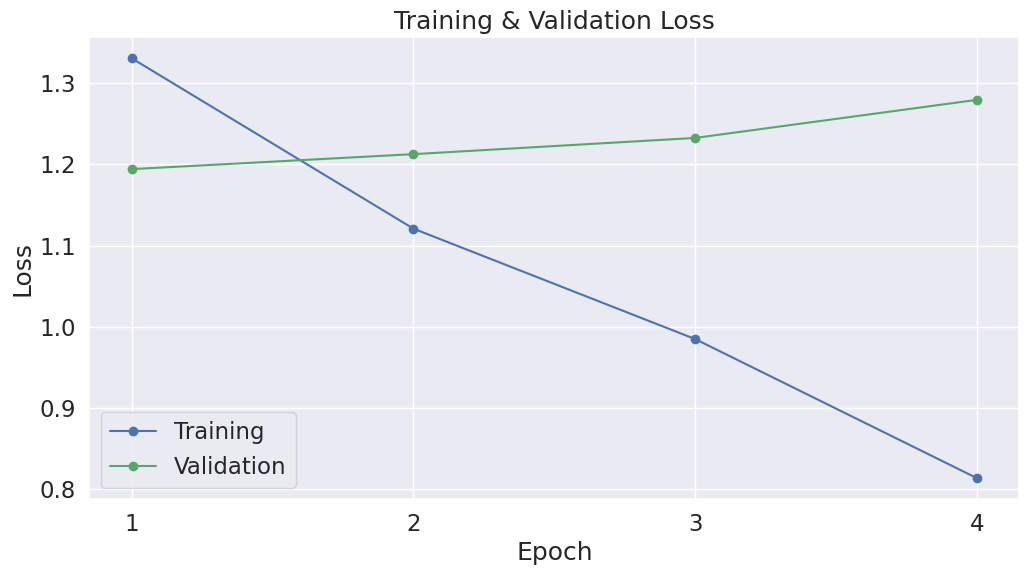

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './final_project_gpt2_textgen_class2'
output_dir1 = './final_project_gpt2_tokenizer_class2'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir1)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./final_project_gpt2_textgen_class2


('./final_project_gpt2_tokenizer_class2/tokenizer_config.json',
 './final_project_gpt2_tokenizer_class2/special_tokens_map.json',
 './final_project_gpt2_tokenizer_class2/vocab.json',
 './final_project_gpt2_tokenizer_class2/merges.txt',
 './final_project_gpt2_tokenizer_class2/added_tokens.json')

In [ ]:
import random

print("Here are example of ten sentences from the original text:")
for x in range(10):
  print(f"{x}: {docs[random.randint(0,len(docs))]}")


Here are example of ten sentences from the original text:
0: Felt like propaganda Had intent and pushed the agenda rather than allowing one to draw one's own conclusions. I found this to overshadow the beauty of the cinematography.
1:  star songs  star production This was a terrible production with no life and seemed jumpy and disjointed. It also felt thrown together and not well rehearsed with number dragging on longer than they should and others rushed. Rachel York was OK she was better in Scarlet Pimpernelbut this is not her best performance at all.All in all a disponting version and hard to see how it won a Tony for best revival..but then this isn't the original cast from that Tony winning revival so that may be the problem.
2: Funny Nice set of laughs. Old TV version of medieval subjects are nearly as good as the new ones. Do any of the script writers do research on the original works or are they too intent on putting their own mark on traditional stories?
3: scared me as a child,

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: I will agree with the others I did not get the other  This film is too predictable and over the top. No real insight is given to anything and there is only one brief moment that makes it worth watching. It should not be used in a concert. Only when there is a long concert it is used by professional musicians.


1: Only for fans of the show The series started out good with the first  episodes, but after  episodes, everything really fell apart. We've seen plenty of low budget sci-fi, but this one is nothing special. It has nothing original. It's basically a remake.


2: Boring This was a depressing movie that should have been rated R because it left me with a little bit of a brain fog. I suppose they could have made it better without the sad ending.


3: Not for me I bought this movie because I really like the actors, but the plot was so boring and I didn't care for it. It was like watching a James Bond movie. I didn't like the Bond at all.


4: Good